#### Load and Prepare the Dataset

In [1]:
import pandas as pd
import numpy as np

# Load your merged and feature-engineered dataset
df = pd.read_csv('../data/features_btc_with_sentiment.csv', parse_dates=['Date'])
df = df.sort_values('Date').reset_index(drop=True)

# Drop 'Date' (not needed for training)
features = df.drop(columns=['Date', 'Close'])
target = df['Close'].values.reshape(-1, 1)


### Scale Features and Target Separately

In [2]:
from sklearn.preprocessing import MinMaxScaler

# Scale input features
feature_scaler = MinMaxScaler()
X_scaled = feature_scaler.fit_transform(features)

# Scale target values (Close price)
price_scaler = MinMaxScaler()
y_scaled = price_scaler.fit_transform(target)


#### Create LSTM Sequences

In [3]:
def create_sequences(X, y, window=10):
    X_seq, y_seq = [], []
    for i in range(len(X) - window):
        X_seq.append(X[i:i+window])
        y_seq.append(y[i+window])
    return np.array(X_seq), np.array(y_seq)

window_size = 10
X, y = create_sequences(X_scaled, y_scaled, window=window_size)


#### Train-Test Split

In [4]:
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


### Build and Train the LSTM Model

In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential([
    LSTM(64, activation='tanh', input_shape=(X.shape[1], X.shape[2])),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test, y_test))


Epoch 1/20


/Users/rahulmansharamani/Desktop/Files/Github/llm-enhanced-btc-predictor/venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0085 - val_loss: 0.0026
Epoch 2/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.8350e-04 - val_loss: 0.0022
Epoch 3/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.8609e-04 - val_loss: 0.0013
Epoch 4/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.0601e-04 - val_loss: 0.0013
Epoch 5/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.7912e-04 - val_loss: 0.0044
Epoch 6/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.5049e-04 - val_loss: 0.0019
Epoch 7/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.2534e-04 - val_loss: 0.0011
Epoch 8/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.5046e-04 - val_loss: 0.0035
Epoch 9/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.2823e-04 - val_loss: 0.0018
Epoch 10/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.5995e-04 - val_loss: 9.5696e-04
Epoch 11/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.4592e-04 - val_loss: 9.5645e-04
Epoch 12/20
90/90 ━━━━━━━━━━━━━━━━━━━

#### Make Predictions and Inverse Transform

In [6]:
y_pred = model.predict(X_test)

# Inverse scale both y_test and predictions to original price
y_pred_rescaled = price_scaler.inverse_transform(y_pred)
y_test_rescaled = price_scaler.inverse_transform(y_test)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


#### Plot Actual vs Prediction

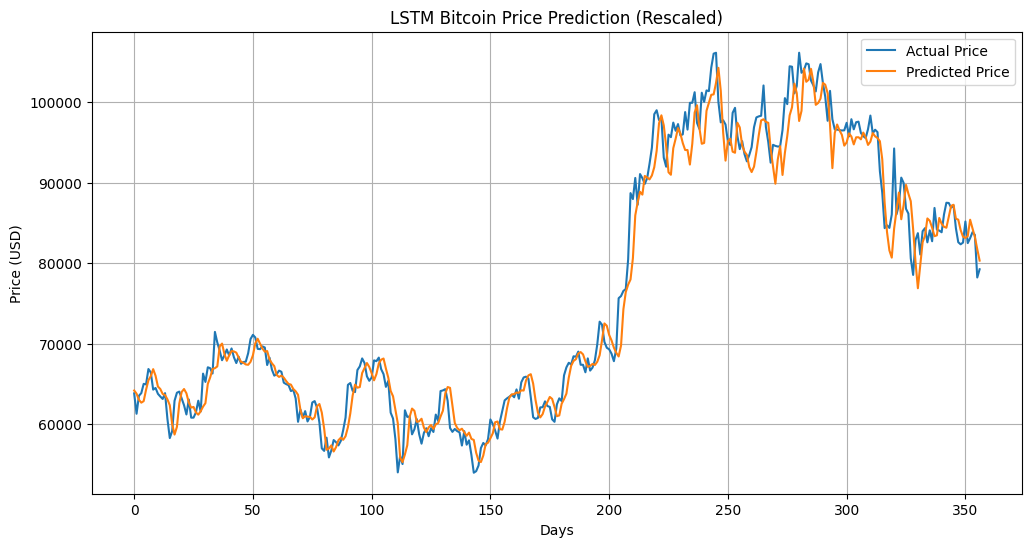

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label='Actual Price')
plt.plot(y_pred_rescaled, label='Predicted Price')
plt.title('LSTM Bitcoin Price Prediction (Rescaled)')
plt.xlabel("Days")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid()
plt.show()


#### Metrics

In [8]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)

print("RMSE:", round(rmse, 2))
print("MAE:", round(mae, 2))


RMSE: 2684.78
MAE: 1986.91


In [9]:
from sklearn.metrics import r2_score
r2 = r2_score(y_test_rescaled, y_pred_rescaled)
print(f"R² Score: {r2:.3f}")



R² Score: 0.971


In [11]:
print(y_pred_rescaled)

[[ 65396.938]
 [ 64330.617]
 [ 63828.418]
 [ 63055.047]
 [ 63285.48 ]
 [ 64385.555]
 [ 65441.92 ]
 [ 66046.945]
 [ 67160.555]
 [ 66936.62 ]
 [ 65774.984]
 [ 65304.184]
 [ 64350.664]
 [ 64137.613]
 [ 63797.285]
 [ 63204.14 ]
 [ 60858.56 ]
 [ 59416.9  ]
 [ 60371.61 ]
 [ 62784.11 ]
 [ 64081.344]
 [ 64846.965]
 [ 64372.41 ]
 [ 63254.93 ]
 [ 62524.47 ]
 [ 62761.746]
 [ 61929.5  ]
 [ 61985.74 ]
 [ 62376.56 ]
 [ 62887.047]
 [ 63375.2  ]
 [ 65603.82 ]
 [ 66272.234]
 [ 67608.59 ]
 [ 67690.61 ]
 [ 68278.71 ]
 [ 70848.26 ]
 [ 70805.41 ]
 [ 69919.11 ]
 [ 69217.01 ]
 [ 69718.96 ]
 [ 69989.81 ]
 [ 70180.02 ]
 [ 69742.305]
 [ 68889.305]
 [ 68641.79 ]
 [ 68440.17 ]
 [ 68195.77 ]
 [ 68449.37 ]
 [ 68891.89 ]
 [ 69833.914]
 [ 71134.414]
 [ 71379.87 ]
 [ 70985.55 ]
 [ 70207.6  ]
 [ 70259.44 ]
 [ 70493.45 ]
 [ 69485.03 ]
 [ 68513.19 ]
 [ 68125.24 ]
 [ 67155.3  ]
 [ 66696.875]
 [ 66686.15 ]
 [ 66897.09 ]
 [ 66615.57 ]
 [ 66062.   ]
 [ 65948.03 ]
 [ 65180.4  ]
 [ 64733.555]
 [ 64618.387]
 [ 62802.543]
 [ 616

In [10]:
import sys
import os

# Add the parent folder (project root) to sys.path
sys.path.append(os.path.abspath(".."))

In [11]:
from src.backtesting_engine import BacktestEngine

In [12]:
# For baseline model
baseline_bt = BacktestEngine(actual=y_test_rescaled.flatten(), predicted=y_pred_rescaled.flatten())
baseline_df = baseline_bt.run()
baseline_bt.summary()

📈 Model Final Portfolio: $1484.18
📉 Buy & Hold Portfolio: $1241.70
Delta: $242.48
Win Rate (buy signal days): 43.82%
